In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime, time
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from difflib import SequenceMatcher
from sklearn.preprocessing import normalize
import math

In [81]:
df = pd.read_csv("within-patch.csv")
pd.set_option('display.max_columns', None)

In [82]:
df['AcceptedAnswerId'] = df['AcceptedAnswerId'].replace(np.nan, 0)
df['Ans_lastEditDate'] = df['Ans_lastEditDate'].replace(np.nan, 0)

In [83]:
p = re.compile(r'<.*?>')

for ind, row in df.iterrows():
    title_count = p.sub('',  df.loc[ind, "Ans_Body"])
    df.loc[ind, "Words_in_Answer_Text"] = len(re.findall(r'\w+',title_count))

In [84]:
for ind, row in df.iterrows():
    if(df.loc[ind,"AcceptedAnswerId"]==df.loc[ind,"Ans_Id"]):
        df.loc[ind, "Accepted_Ans"] = df.loc[ind, "Ans_Score"]*2
    else:
        df.loc[ind, "Accepted_Ans"] = df.loc[ind, "Ans_Score"]*1.5

In [85]:
substring = "<code>"

for ind, row in df.iterrows():
    if(substring in df.loc[ind,"Ans_Body"]):
        df.loc[ind, "Code_Snippet"] = 1
    else:
        df.loc[ind, "Code_Snippet"] = 0

In [86]:
p = re.compile(r'<.*?>')

for ind, row in df.iterrows():
    title_text = p.sub('',  df.loc[ind, "Title_Body"])
    answer_text = p.sub('',  df.loc[ind, "Ans_Body"])
    question = re.findall(r'\w+',title_text)
    answer = re.findall(r'\w+',answer_text)
    df.loc[ind, "description_answer_ratio"] = math.ceil(SequenceMatcher(None, title_text,answer_text).ratio())

In [87]:
p = re.compile(r'<.*?>')

for ind, row in df.iterrows():
    title_text = p.sub('',  df.loc[ind, "Title"])
    answer_text = p.sub('',  df.loc[ind, "Ans_Body"])
    question = re.findall(r'\w+',title_text)
    answer = re.findall(r'\w+',answer_text)
    df.loc[ind, "que_answer_ratio"] = math.ceil(SequenceMatcher(None, title_text,answer_text).ratio()*100)

In [88]:
df['Words_in_Answer_Text'] = df['Words_in_Answer_Text'].astype(int)
df['Accepted_Ans'] = df['Accepted_Ans'].astype(int)
df['Code_Snippet'] = df['Code_Snippet'].astype(int)
df['description_answer_ratio'] = df['description_answer_ratio'].astype(int)
df['que_answer_ratio'] = df['que_answer_ratio'].astype(int)

In [90]:
df.drop(['Id', 'Score','Title', 'Title_Body', 'CreationDate','AcceptedAnswerId', 'Ans_Id','Ans_Score','Ans_Body','Ans_creationDate','Ans_lastEditDate','Ans_Auth_reputation','Accepted_Ans','Code_Snippet','description_answer_ratio'], axis=1, inplace=True)

In [92]:
data_scaled = normalize(df)

In [93]:
hc = AgglomerativeClustering(n_clusters=2,affinity="euclidean",linkage="ward")
hc.fit(data_scaled)

AgglomerativeClustering()

In [94]:
membership = hc.labels_
membership

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [95]:
df_0 = df[hc.labels_==0]

In [96]:
df_1 = df[hc.labels_==1]

In [101]:
df_0.to_csv('within_cost_low.csv')

In [102]:
df_1.to_csv('within_cost_high.csv')

In [103]:
silhouette_score(data_scaled,membership)

0.8467855535164945

In [104]:
df.loc[:,"Category"]=0
df.loc[hc.labels_==1, "Category"] = 1

In [105]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from statsmodels.regression.linear_model import OLSResults

In [106]:
feature_names = ['Ans_CommentCount','Words_in_Answer_Text','que_answer_ratio']
nrm_feature_names = [f"Nrm_{i}" for i in feature_names]

In [107]:
scaler = MinMaxScaler()
features = df[feature_names]
nrm_feature_names = [f"Nrm_{i}" for i in feature_names]
scaler.fit(features)
for i in nrm_feature_names:
    df[i] = 0
df[nrm_feature_names] = scaler.transform(features)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(df[nrm_feature_names], df["Category"], test_size=0.3, random_state=62)

In [118]:
lm_cluster_cost = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.007528
         Iterations 24


In [119]:
print(lm_cluster_cost.summary())

                           Logit Regression Results                           
Dep. Variable:               Category   No. Observations:                 3033
Model:                          Logit   Df Residuals:                     3030
Method:                           MLE   Df Model:                            2
Date:                Sun, 05 Dec 2021   Pseudo R-squ.:                  0.9819
Time:                        15:21:36   Log-Likelihood:                -22.833
converged:                       True   LL-Null:                       -1264.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Nrm_Ans_CommentCount        20.9536      7.672      2.731      0.006       5.916      35.991
Nrm_Words_in_Answer_Text  2652.1889    567.804      4.671      0.000    1539.314    3765.

In [120]:
y_pred = [1 if i else 0 for i in lm_cluster_cost.predict(X_test)>0.5]

In [121]:
data_summary = {}

Confusion Matrix: 
[[ 188    0]
 [   0 1113]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0


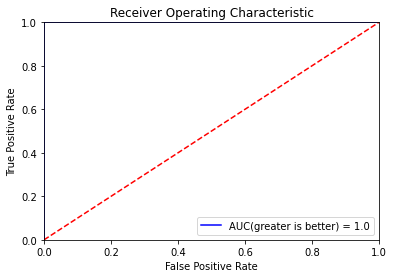

In [122]:
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
fpr, tpr, thresholds = roc_curve(y_test, lm_cluster_cost.predict(X_test), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC(greater is better) = {round(roc_auc, 5)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

data_summary["Exetrems_Model_Testing_Dataset"] = {}
data_summary["Exetrems_Model_Testing_Dataset"]["Accuracy"] = accuracy_score(y_test, y_pred)
data_summary["Exetrems_Model_Testing_Dataset"]["Precision"] = precision_score(y_test, y_pred)
data_summary["Exetrems_Model_Testing_Dataset"]["Recall"] = recall_score(y_test, y_pred)
data_summary["Exetrems_Model_Testing_Dataset"]["AUC"] = auc(fpr, tpr)

Confusion Matrix: 
[[ 442    3]
 [   4 2584]]
Accuracy: 0.997692054071876
Precision: 0.9988403556242752
Recall: 0.9984544049459042


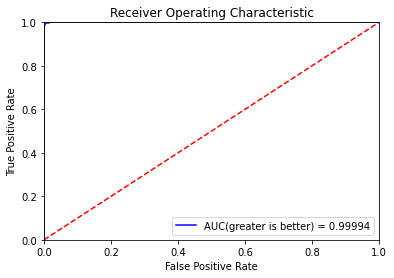

In [123]:
y_pred = [1 if i else 0 for i in lm_cluster_cost.predict(X_train)>0.5]
print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_pred)}")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred)}")
print(f"Recall: {recall_score(y_train, y_pred)}")
fpr, tpr, thresholds = roc_curve(y_train, lm_cluster_cost.predict(X_train), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC(greater is better) = {round(roc_auc, 5)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

data_summary["Exetrems_Model_Training_Dataset"] = {}
data_summary["Exetrems_Model_Training_Dataset"]["Accuracy"] = accuracy_score(y_train, y_pred)
data_summary["Exetrems_Model_Training_Dataset"]["Precision"] = precision_score(y_train, y_pred)
data_summary["Exetrems_Model_Training_Dataset"]["Recall"] = recall_score(y_train, y_train)
data_summary["Exetrems_Model_Training_Dataset"]["AUC"] = auc(fpr, tpr)

In [124]:
df_python = pd.read_csv('within-python.csv')

Confusion Matrix: 
[[    0  5942]
 [    0 14058]]
Accuracy: 0.7029
Precision: 0.7029
Recall: 1.0


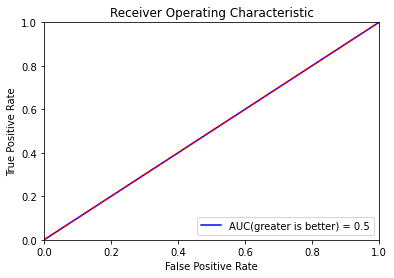

In [128]:
X_train, y_train = df_python[feature_names], df_python["Category"]
y_pred = [1 if i else 0 for i in lm_cluster_cost.predict(X_train)>0.5]
print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_pred)}")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Precision: {precision_score(y_train, y_pred)}")
print(f"Recall: {recall_score(y_train, y_pred)}")
fpr, tpr, thresholds = roc_curve(y_train, lm_cluster_cost.predict(X_train), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC(greater is better) = {round(roc_auc, 5)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


data_summary["Exetrems_Model_Python_Dataset"] = {}
data_summary["Exetrems_Model_Python_Dataset"]["Accuracy"] = accuracy_score(y_train, y_pred)
data_summary["Exetrems_Model_Python_Dataset"]["Precision"] = precision_score(y_train, y_pred)
data_summary["Exetrems_Model_Python_Dataset"]["Recall"] = recall_score(y_train, y_pred)
data_summary["Exetrems_Model_Python_Dataset"]["AUC"] = auc(fpr, tpr)